In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Activities
I use pandas to read in the large file containing activity reports and narrow it down to the columns I want to look at.

In [2]:
activities = pd.read_csv('data/atusact_2014.dat')
activities = activities[['TUCASEID', 'TUACTIVITY_N', 'TUTIER1CODE', 'TUTIER2CODE', 'TUTIER3CODE', 'TRCODE', 'TRTIER2', 'TUACTDUR']]
activities.head()

,TUCASEID,TUACTIVITY_N,TUTIER1CODE,TUTIER2CODE,TUTIER3CODE,TRCODE,TRTIER2,TUACTDUR
0,20140101140007,1,1,1,1,10101,101,540
1,20140101140007,2,3,1,1,30101,301,30
2,20140101140007,3,1,2,1,10201,102,60
3,20140101140007,4,18,11,1,181101,1811,10
4,20140101140007,5,11,1,1,110101,1101,30


### Roster
I used pandas to read in the roster data file and narrow down the data frame to useful information. I dropped columns I didn't want to look at, and only kept information for respondents ('TULINENO' code 1).

In [3]:
roster = pd.read_csv('data/atusrost_2014.dat')
roster.drop(['TXSEX', 'TXRRP', 'TXAGE', 'TERRP'], 1, inplace=True)
roster = roster[roster['TULINENO'] == 1]
roster.drop('TULINENO', 1, inplace=True)
roster.head()

,TUCASEID,TEAGE,TESEX
0,20140101140007,20,2
3,20140101140011,16,2
5,20140101140028,65,2
11,20140101140063,50,2
12,20140101140168,23,2


I merged the roster data frame with the activities data frame so that I have the sex and age of every person along with their reports.

In [4]:
act_rost = pd.merge(roster, activities)
act_rost.head()

,TUCASEID,TEAGE,TESEX,TUACTIVITY_N,TUTIER1CODE,TUTIER2CODE,TUTIER3CODE,TRCODE,TRTIER2,TUACTDUR
0,20140101140007,20,2,1,1,1,1,10101,101,540
1,20140101140007,20,2,2,3,1,1,30101,301,30
2,20140101140007,20,2,3,1,2,1,10201,102,60
3,20140101140007,20,2,4,18,11,1,181101,1811,10
4,20140101140007,20,2,5,11,1,1,110101,1101,30


I created a data frame of every report of eating (code 11).

In [5]:
eating = act_rost[act_rost.TUTIER1CODE == 11]
eating.head()

,TUCASEID,TEAGE,TESEX,TUACTIVITY_N,TUTIER1CODE,TUTIER2CODE,TUTIER3CODE,TRCODE,TRTIER2,TUACTDUR
4,20140101140007,20,2,5,11,1,1,110101,1101,30
14,20140101140011,16,2,5,11,1,1,110101,1101,15
23,20140101140011,16,2,14,11,1,1,110101,1101,30
30,20140101140028,65,2,3,11,1,1,110101,1101,60
51,20140101140168,23,2,5,11,1,1,110101,1101,15


### FINDING OUTLIERS

I used the following method to find outliers in the data set and get rid of them. 

1. Make a copy of original df<br>
    newdf = df.copy()
<br><br>
2. Get difference in value and mean of values.<br>
    newdf['x-Mean'] = abs(newdf['column'] - newdf['column'].mean())
<br><br>
3. Get limits for outliers by calculating standard deviation times 1.96.<br>
    newdf['1.96\*std'] = 1.96\*newdf['column'].std()
<br><br>
4. The Outlier compares the difference from mean with the outlier limit and returns a boolean value for whether the difference it too great.<br>
    newdf['Outlier'] = newdf['x-Mean'] > newdf['1.96\*std']
<br><br>
5. Delete outliers.<br>
    Reset the data frame to values that are not outliers.

In [6]:
eat = eating.copy()
eat['x-Mean'] = abs(eat.TUACTDUR - eat.TUACTDUR.mean())
eat['1.96*std'] = 1.96*eat.TUACTDUR.std()
eat['Outlier'] = eat['x-Mean'] > eat['1.96*std']
eat = eat[eat.Outlier == False]
eat.head()

,TUCASEID,TEAGE,TESEX,TUACTIVITY_N,TUTIER1CODE,TUTIER2CODE,TUTIER3CODE,TRCODE,TRTIER2,TUACTDUR,x-Mean,1.96*std,Outlier
4,20140101140007,20,2,5,11,1,1,110101,1101,30,2.760182,56.883675,False
14,20140101140011,16,2,5,11,1,1,110101,1101,15,17.760182,56.883675,False
23,20140101140011,16,2,14,11,1,1,110101,1101,30,2.760182,56.883675,False
30,20140101140028,65,2,3,11,1,1,110101,1101,60,27.239818,56.883675,False
51,20140101140168,23,2,5,11,1,1,110101,1101,15,17.760182,56.883675,False


After deleting the outliers, I used groupby and aggregate methods to create a dataframe with the number of meals each respondent had and the total duration of time they spent eating.

In [7]:
eat_len = eat.groupby([eat.TUCASEID, eat.TEAGE, eat.TESEX])
eat_len = eat_len.agg({'TUACTDUR': np.sum, 'TUACTIVITY_N': np.size})
eat_len.rename(columns={'TUACTIVITY_N':'meals'}, inplace=True)
eat_len.reset_index(inplace=True)
eat_len.head()

,TUCASEID,TEAGE,TESEX,TUACTDUR,meals
0,20140101140007,20,2,30,1
1,20140101140011,16,2,45,2
2,20140101140028,65,2,60,1
3,20140101140168,23,2,65,3
4,20140101140537,85,1,30,1


### How often and how long do people eat?
From here I was able to compare reports of eating based on age and sex.

In [9]:
w_eat_len = eat_len[eat_len.TESEX == 2].mean().TUACTDUR
m_eat_len = eat_len[eat_len.TESEX == 1].mean().TUACTDUR
print('Women spent an average of {} minutes eating, while men spent an average of {} minutes eating.'.format(round(w_eat_len, 2), round(m_eat_len, 2)))

Women spent an average of 57.29 minutes eating, while men spent an average of 60.69 minutes eating.


In [10]:
kids_eat = eat_len[eat_len.TEAGE <= 18].mean().TUACTDUR
adults_eat = eat_len[eat_len.TEAGE > 18].mean().TUACTDUR
print('People ages 18 and under spent an average of {} minutes eating, while people over 18 years old spent an average of {} minutes eating.'.format(round(kids_eat, 2), round(adults_eat, 2)))

People ages 18 and under spent an average of 52.97 minutes eating, while people over 18 years old spent an average of 59.07 minutes eating.


## Calculating % of Male/Female respondents reporting an activity
I used the roster data frame to find the number of respondents of each sex.

In [37]:
r_copy = roster.copy()
r_counts = r_copy.groupby(['TESEX', 'TEAGE']).count()
r_counts.rename(columns={'TUCASEID': 'resp_count'}, inplace=True)
r_counts.reset_index(inplace=True)
r_counts.head()

,TESEX,TEAGE,resp_count
0,1,15,56
1,1,16,92
2,1,17,80
3,1,18,50
4,1,19,41


I used the merged activities and roster data to find the number of reports of each type by sex.

In [38]:
ar_copy = act_rost.copy()
ar_copy.drop(['TUACTIVITY_N', 'TRCODE', 'TRTIER2'], 1, inplace=True)
activities_count = ar_copy.groupby(['TUTIER1CODE', 'TUTIER2CODE', 'TUTIER3CODE', 'TESEX', 'TEAGE'])
activities_count = activities_count.agg({'TUCASEID': np.size, 'TUACTDUR': np.mean})
activities_count.rename(columns={'TUCASEID': 'reports', 'TUACTDUR': 'duration'}, inplace=True)
activities_count.reset_index(inplace=True)
activities_count.head()

,TUTIER1CODE,TUTIER2CODE,TUTIER3CODE,TESEX,TEAGE,reports,duration
0,1,1,1,1,15,114,395.052632
1,1,1,1,1,16,193,387.792746
2,1,1,1,1,17,173,392.942197
3,1,1,1,1,18,107,378.654206
4,1,1,1,1,19,89,392.280899


I merged the counts of repondents by sex with the counts and durations of of activities by activity and sex. I used the # of reports and # of respondents to calculate the percentage of respondents that reported engaging in a given activity. I also created a multi-index frame so that I could easily access the stats by activity.

In [41]:
act_rost_reports = pd.merge(activities_count, r_counts, on=['TESEX', 'TEAGE'], how='outer')
act_rost_reports['reports_per_resp'] = act_rost_reports.reports / act_rost_reports.resp_count
act_rost_reports.drop('resp_count', 1, inplace=True)
act_rost_reports = act_rost_reports.groupby(['TUTIER1CODE', 'TUTIER2CODE', 'TUTIER3CODE', 'TESEX', 'TEAGE']).sum()
act_rost_reports.head()

reports    duration  \
TUTIER1CODE TUTIER2CODE TUTIER3CODE TESEX TEAGE                        
1           1           1           1     15         114  395.052632   
                                          16         193  387.792746   
                                          17         173  392.942197   
                                          18         107  378.654206   
                                          19          89  392.280899   

                                                 reports_per_resp  
TUTIER1CODE TUTIER2CODE TUTIER3CODE TESEX TEAGE                    
1           1           1           1     15             2.035714  
                                          16             2.097826  
                                          17             2.162500  
                                          18             2.140000  
                                          19             2.170732

### Make up of people who reported socializing/comunicating with others:
Using the three part code for socializing/communicating and the code for sex, I am able to access this specific information.<br><br>62.41% of women reported socializing/communicating for an average of 68.7 minutes. <br>53.48% of men reported socializing/communicating for an average of 77.9 minutes.

In [44]:
act_rost_reports.loc[12].loc[1].loc[1].loc[2].mean()

reports             59.089552
duration            68.688531
reports_per_resp     0.624162
dtype: float64

In [45]:
act_rost_reports.loc[12].loc[1].loc[1].loc[1].mean()

reports             40.238806
duration            77.921545
reports_per_resp     0.534767
dtype: float64

### Comparing Male/Female reports of house-cleaning across age
The following plot shows the percentage of male and female respondents of each age that reported interior house cleaning. It is very clear from the graph that women, regardless of age, are more likely to spend time cleaning the house than men.

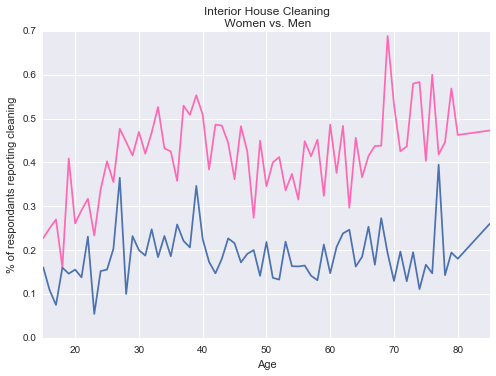

In [48]:
w = act_rost_reports.loc[2].loc[1].loc[1].loc[2]['reports_per_resp']
m = act_rost_reports.loc[2].loc[1].loc[1].loc[1]['reports_per_resp']

w.plot(kind='line', c='hotpink')
m.plot(kind='line')
plt.title('Interior House Cleaning\n Women vs. Men')
plt.xlabel('Age')
plt.ylabel('% of respondants reporting cleaning')
plt.show()

# Correlation
The activities summary file containes the duration that each repsondent spent doing all reported tasks as well as informatin like their age and sex. I used pandas .corr() method to create a data frame of correlation coefficients on that data. I also replaced values of 1 (where the column was compared against itself) to values of NaN.

In [14]:
act_sum = pd.read_csv('data/atussum_2014.dat')
act_sum.head()
cor = act_sum.corr()
cor.replace(to_replace=1, value=np.nan, inplace=True)
cor.head()

,tucaseid,TUFINLWGT,TRYHHCHILD,TEAGE,TESEX,PEEDUCA,PTDTRACE,PEHSPNON,GTMETSTA,TELFS,...,t181601,t181699,t181801,t181899,t189999,t500101,t500103,t500105,t500106,t500107
tucaseid,NaN,0.032235,0.006124,-0.007162,-0.017115,-0.014749,0.000874,-0.006381,0.014979,-0.010093,...,-0.005859,-0.006674,-0.005857,-0.009457,-0.004173,-0.040702,-0.016699,0.002191,-0.017501,-0.009540
TUFINLWGT,0.032235,NaN,-0.020603,-0.213174,-0.093590,-0.135534,-0.004744,-0.025933,-0.011965,-0.027283,...,-0.004466,0.001674,-0.008920,-0.008441,-0.008630,0.005873,0.001493,0.010360,-0.017711,-0.006392
TRYHHCHILD,0.006124,-0.020603,NaN,-0.365897,0.004457,-0.080447,0.023713,-0.032566,-0.003213,-0.127396,...,-0.003802,-0.002671,-0.001719,0.003602,0.020722,0.015719,0.013646,0.000088,-0.035564,0.020727
TEAGE,-0.007162,-0.213174,-0.365897,NaN,0.051919,0.023732,-0.077561,0.128753,0.040644,0.358194,...,0.002560,-0.007163,-0.008693,0.006390,-0.002466,-0.012960,-0.012961,-0.018435,0.099584,-0.000314
TESEX,-0.017115,-0.093590,0.004457,0.051919,NaN,0.014751,-0.008349,0.005778,-0.008446,0.148272,...,-0.001596,0.008267,0.009822,-0.014759,-0.004464,0.009056,0.015994,-0.005071,0.018821,0.010795


#### Correlation between sex and house cleaning
From here I used scatter plots to determine correlations within the data. The following plot shows a positive correlation between sex and time spent cleaning the house. Since the female sex code is 2, thie positive correlation means that the more likeley a respondent is to be a woman, the more time she is likely to have spent cleaning the house.

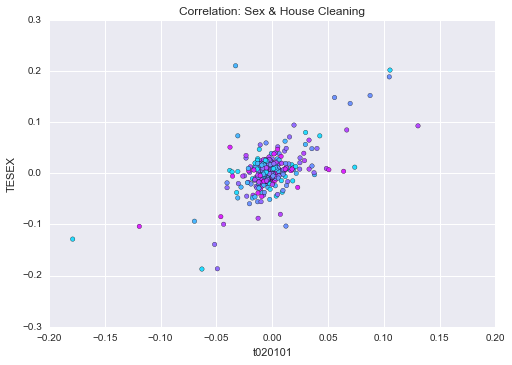

In [15]:
cor.plot(kind='scatter', x='t020101', y='TESEX', c=sns.color_palette('cool'))
plt.title('Correlation: Sex & House Cleaning')
plt.show()

#### Correlation between age and radio listening
The plot below shows a strong positive correlation between age and time spent listening to the radio. As a respondent's age increases, the amount of time they spend listening to the radio also increases.

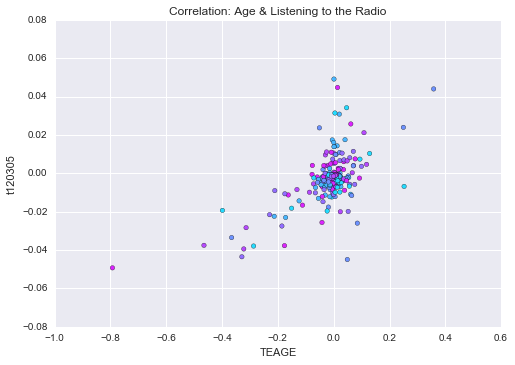

In [16]:
cor.plot(kind='scatter', x='TEAGE', y='t120305', c=sns.color_palette('cool'))
plt.title('Correlation: Age & Listening to the Radio')
plt.show()